In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
import os
sys.path.append(os.path.join("./", "..", ".."))

In [2]:
config_path = './../../configs/vae.json'
import json
from types import SimpleNamespace
config = SimpleNamespace(**json.load(open(config_path, 'r')))

In [3]:
# X = pd.read_csv('./../../Data/breast/breast.csv', usecols = ['radius_mean', 'texture_mean', 'perimeter_mean',
#        'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean',
#        'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean',
#        'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se',
#        'compactness_se', 'concavity_se', 'concave points_se', 'symmetry_se',
#        'fractal_dimension_se', 'radius_worst', 'texture_worst',
#        'perimeter_worst', 'area_worst', 'smoothness_worst',
#        'compactness_worst', 'concavity_worst', 'concave points_worst',
#        'symmetry_worst', 'fractal_dimension_worst']).to_numpy()

# def f(x):
#     if x == 'M':
#         return 1
#     else:
#         return 0
# y = pd.read_csv('./../../Data/breast/breast.csv', usecols = ['diagnosis'])['diagnosis'].apply(f).to_numpy()

# X = X - np.min(X, axis = 0)
# X = X / np.max(X, axis = 0)


# np.savetxt("./../../Data/breast/X.tsv", X, delimiter="\t")
# np.savetxt("./../../Data/breast/y.tsv", y, delimiter="\t")

In [4]:
config

namespace(features_path='./Reproduction/Housing/Data/X.tsv',
          labels_path='./Reproduction/Housing/Data/y.tsv',
          model_dir='./Models/',
          batch_size=128,
          min_epochs=200,
          stopping_epochs=25,
          tol=0.001,
          eval_freq=1,
          lr=0.001)

In [5]:
config.features_path = "./../../Data/breast/X.tsv"
config.labels_path = "./../../Data/breast/y.tsv"
config.model_dir = './../../Models'
config.dataset = "breast"
config.lr = 0.005

In [6]:
from Model import *
train_model = False
if train_model:
    model = Model.Initialize('vae', None, pretrained_path=None, config=config)
else:
    model = Model.Initialize('vae', None, pretrained_path='./../../Models/scvis_breast.pt', config=config)

Loading the pretrained model...


In [7]:
x = pd.read_csv('./../../Data/breast/X.tsv', sep="\t").to_numpy()
data_rep = model.Encode(x)

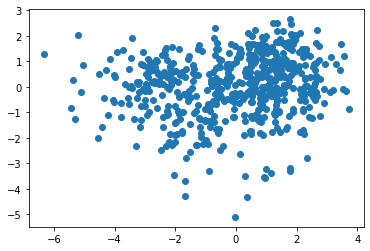

In [8]:
plt.scatter(data_rep[:,0], data_rep[:,1])
plt.show()

In [9]:
from sklearn.cluster import KMeans
num_clusters = 3

kmeans = KMeans(n_clusters = num_clusters, random_state=0).fit(data_rep)

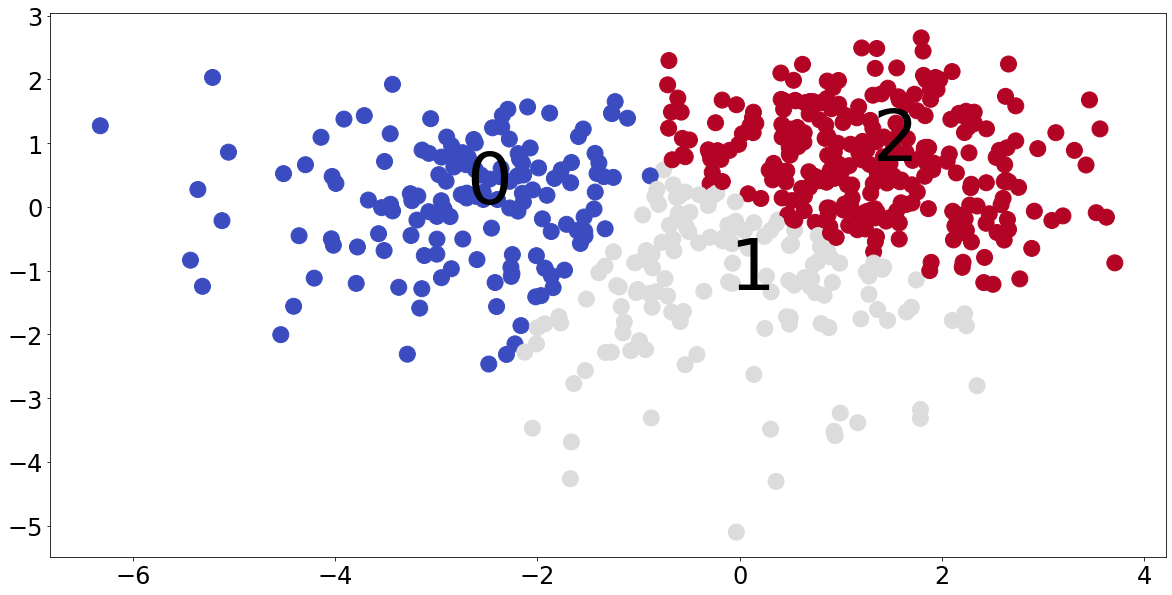

In [10]:
from eldr.plotter.myplot import *
means, centers, indices = plot_groups(x, data_rep.numpy(), num_clusters, kmeans.labels_, name = "./synth-rep.png")

In [11]:
from eldr.explain.explain_cs import *
epsilon = 0

Explainer = Explain(model, means, centers, use_scaling=False)

epsilons = np.linspace(0, 2.0, num=100).tolist()
for iter_epsilon in epsilons:
    mean_, min_, max_ = Explainer.eval_epsilon(torch.tensor(x), indices, iter_epsilon)
    if mean_ >= 0.95 and min_ >= 0.95 and max_>= 0.95:
        epsilon = iter_epsilon
        break
print(epsilon)

0.4646464646464647


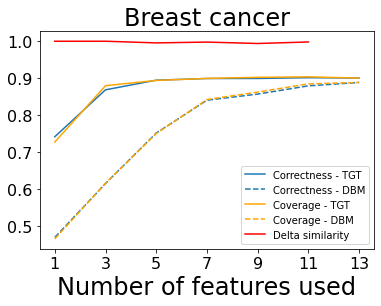

In [12]:
from eldr.misc import load
import matplotlib
matplotlib.rc("xtick", labelsize = 16)
matplotlib.rc("ytick", labelsize = 16)
matplotlib.rc("axes", titlesize = 24)
matplotlib.rc("axes", labelsize = 24)

K = [1, 3, 5, 7, 9, 11, 13]


out_path = './out.csv'
out = np.loadtxt(out_path, delimiter=",")
S_deltas = np.zeros(len(K) - 1)
S_range = []
for c in range(len(K) - 1):
    k_more = K[c]
    k_less = K[c + 1]
    
    d_more = np.load("./deltas/deltas" + str(k_more) + ".npy")
    d_less = np.load("./deltas/deltas" + str(k_less) + ".npy")
    
    res_deltas = np.ones((num_clusters, num_clusters))
    res_gammas = np.ones((num_clusters, num_clusters))
    
    for i in range(num_clusters):
        for j in range(num_clusters):
            if i != j:
                e_d_more = load(d_more, k_more, i, j).numpy()
                e_d_less = load(d_less, k_less, i, j).numpy()
                
                res_deltas[i,j] = Explainer.similarity(e_d_more, e_d_less)
    S_deltas[c] = np.mean(res_deltas)
    S_range.append(k_more)
    
plt.plot(out[:, 0], out[:, 1], c = "C0", label = "Correctness - TGT")
plt.plot(out[:, 0], out[:, 3], ls = "--", c= "C0", label = "Correctness - DBM")
plt.plot(out[:, 0], out[:, 2], c = "orange", label = "Coverage - TGT")
plt.plot(out[:, 0], out[:, 4], ls = "--", color = "orange", label = "Coverage - DBM")
plt.plot(S_range, S_deltas, c = 'red', label='Delta similarity')
plt.xlabel('Number of features used')
plt.title('Breast cancer')
plt.xticks(np.arange(1, 15, step=2))
plt.legend()

plt.savefig("breast-tradeoff.png", bbox_inches='tight')
plt.show()
plt.close()